# Poseidon - Multi Seismic to Well Tie

In [1]:
import numpy as np
import pandas as pd

import yaml

from pprint import pprint
from pathlib import Path


import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
from wtie import grid, tie, autotie, viz

from wtie.optimize import similarity 
from wtie.learning.network import VariationalNetwork
from wtie.learning.model import VariationalEvaluator

In [3]:
from wtie.utils.datasets import tutorial

### Import Data

In [4]:
folder = Path('/home/valentin/code/itwm/well-tie/data/tutorial/')
inputs = {'boreas':tutorial.load_poseidon_data(folder, well='boreas1'),
          'torosa':tutorial.load_poseidon_data(folder, well='torosa1')
         }

### Load Network

In [5]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from /home/valentin/code/itwm/well-tie/data/tutorial/trained_net_state_dict.pt


/home/valentin/anaconda3/envs/wtie/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)



In [6]:
expected_sampling = training_parameters['synthetic_dataset']['dt']
expected_Nyquist = 1.0 / (2*expected_sampling)
print(expected_sampling, expected_Nyquist)

0.002 250.0


### Other utils

In [7]:
modeler = tutorial.get_modeling_tool()

## Automatic Tie
### Part1 - Logs processing and bulk shift

In [8]:
# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.010, 0.010], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

In [9]:
search_params = dict(num_iters=65, similarity_std=0.02)
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)
ss_params = dict(window_length=0.060, max_lag=0.010) # in seconds

In [10]:
import warnings
warnings.filterwarnings('ignore')

outputs = {}
for well in inputs.keys():
    outputs[well] = autotie.tie_v1(inputs[well],
                             wavelet_extractor,
                             modeler,
                             wavelet_scaling_params,
                             search_params=search_params,
                             search_space=search_space,
                             stretch_and_squeeze_params=ss_params) 



Search for optimal parameters


100%|██████████| 65/65 [01:14<00:00,  1.15s/it]


Find wavelet absolute scale


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


Search for optimal parameters


100%|██████████| 65/65 [03:13<00:00,  2.98s/it]


Find wavelet absolute scale


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


In [11]:
for well in inputs.keys():
    best_parameters, _ = outputs[well].ax_client.get_best_parameters()
    print(well,best_parameters)

boreas {'logs_median_threshold': 3.9449342846870428, 'logs_std': 2.5229700207710266, 'table_t_shift': -0.004087514877319336, 'logs_median_size': 19}
torosa {'logs_median_threshold': 2.6470907509326937, 'logs_std': 2.781707227230072, 'table_t_shift': 0.009957094192504881, 'logs_median_size': 13}


<IPython.core.display.Javascript object>


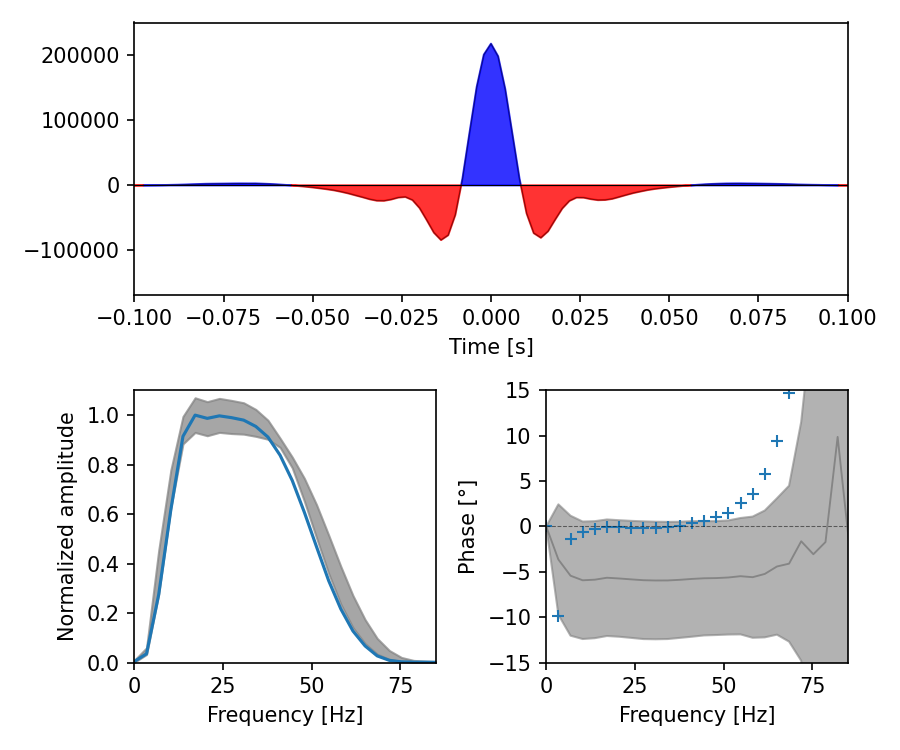

<IPython.core.display.Javascript object>


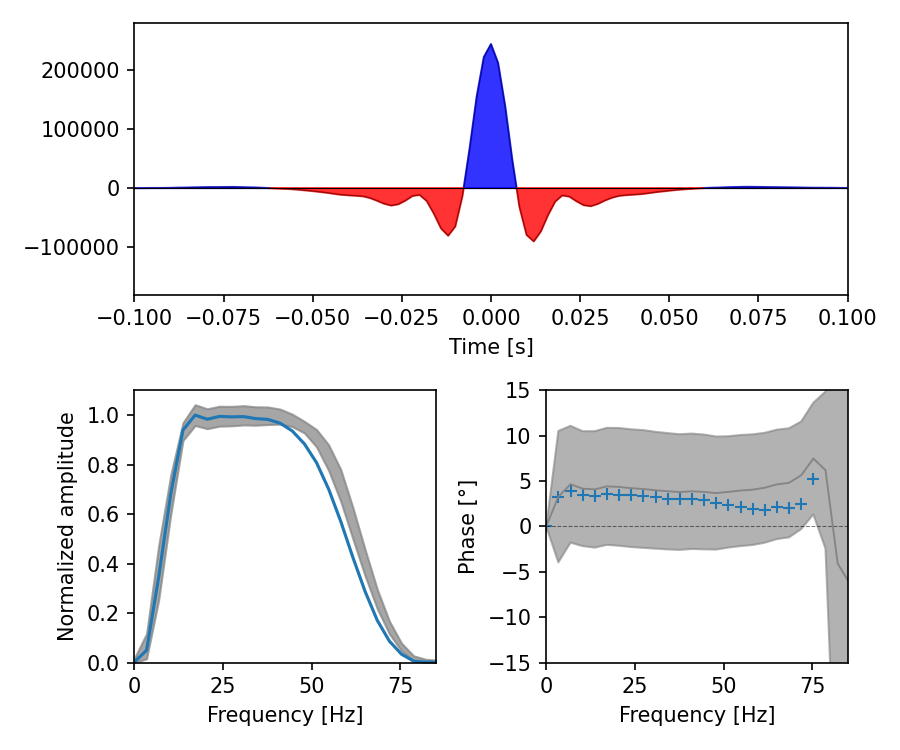

(<Figure size 600x500 with 3 Axes>,
 [<AxesSubplot:xlabel='Time [s]'>,
  <AxesSubplot:xlabel='Frequency [Hz]', ylabel='Normalized amplitude'>,
  <AxesSubplot:xlabel='Frequency [Hz]', ylabel='Phase [°]'>])

In [12]:
outputs['boreas'].plot_wavelet(figsize=(6,5), fmax = 85, phi_max = 15, abs_t_max=0.1)
outputs['torosa'].plot_wavelet(figsize=(6,5), fmax = 85, phi_max = 15, abs_t_max=0.1)

<IPython.core.display.Javascript object>


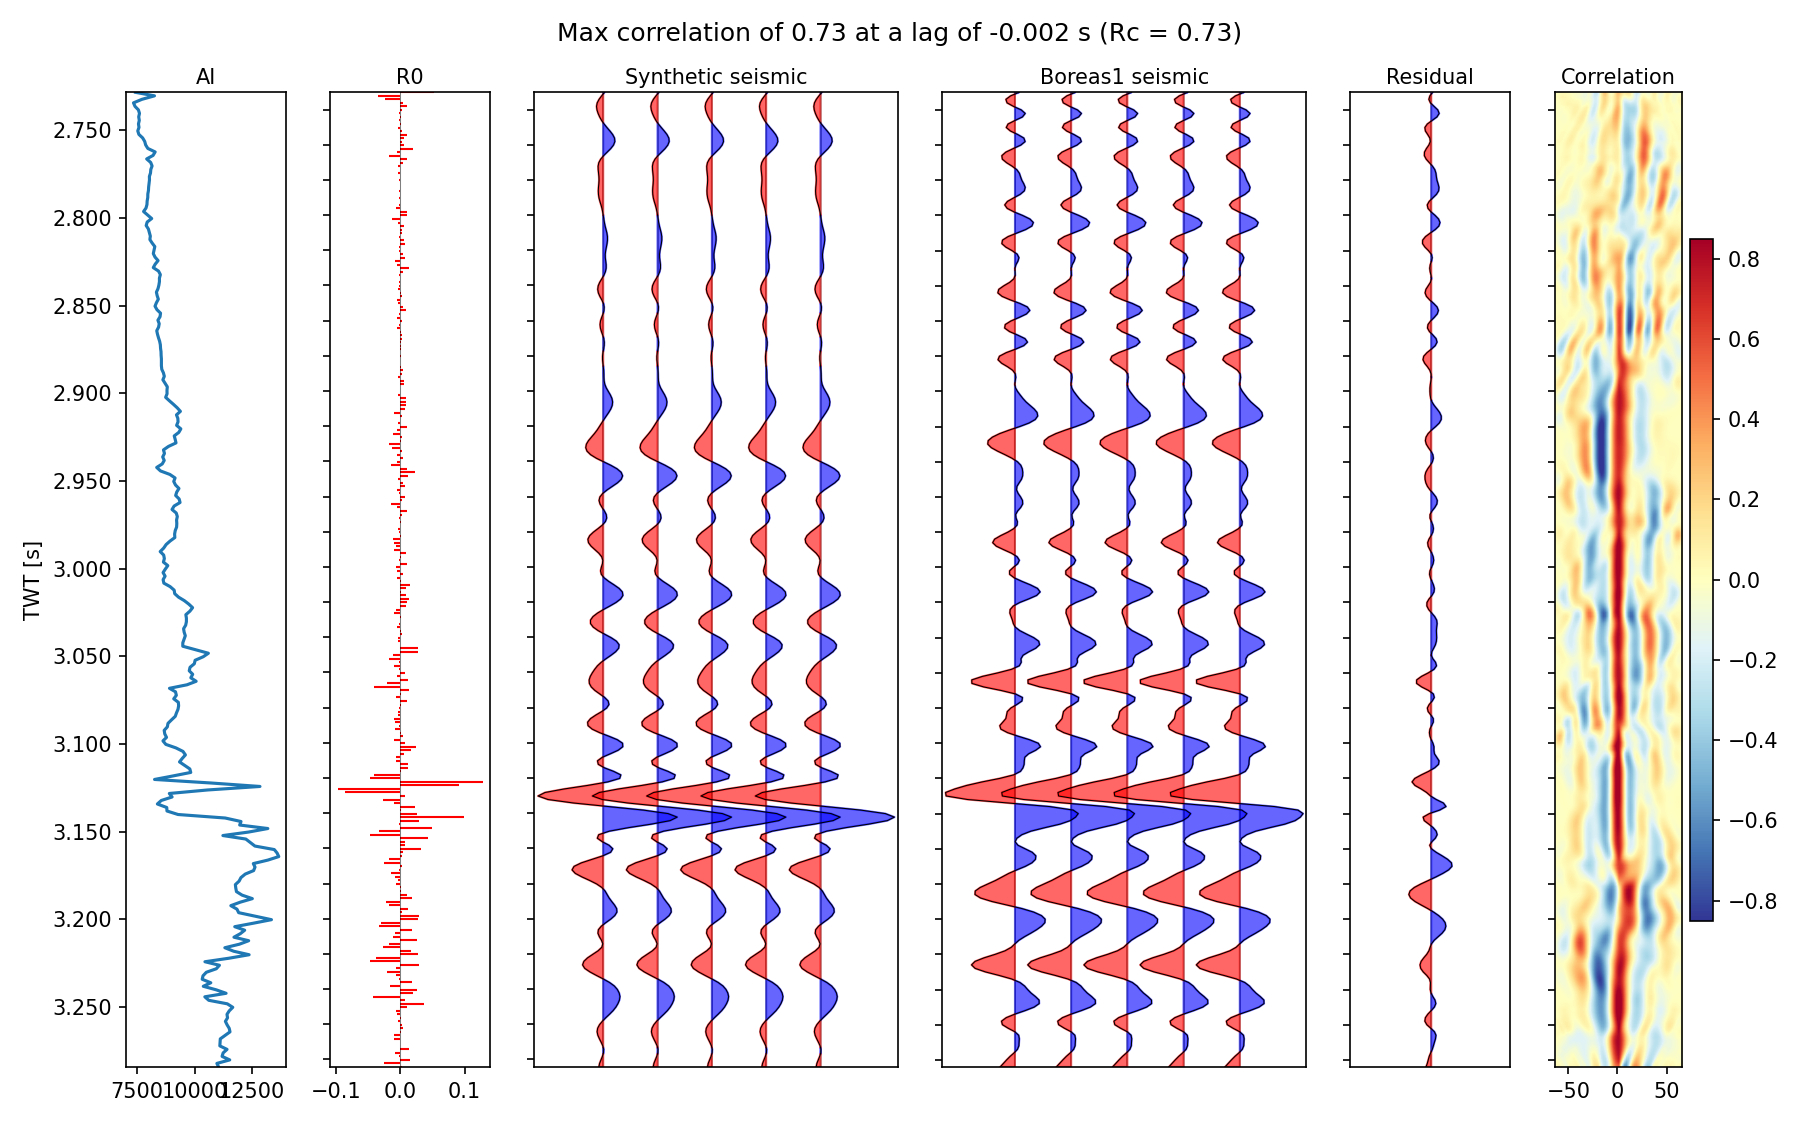

In [13]:
_scale = 120000
fig, axes = outputs['boreas'].plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

<IPython.core.display.Javascript object>


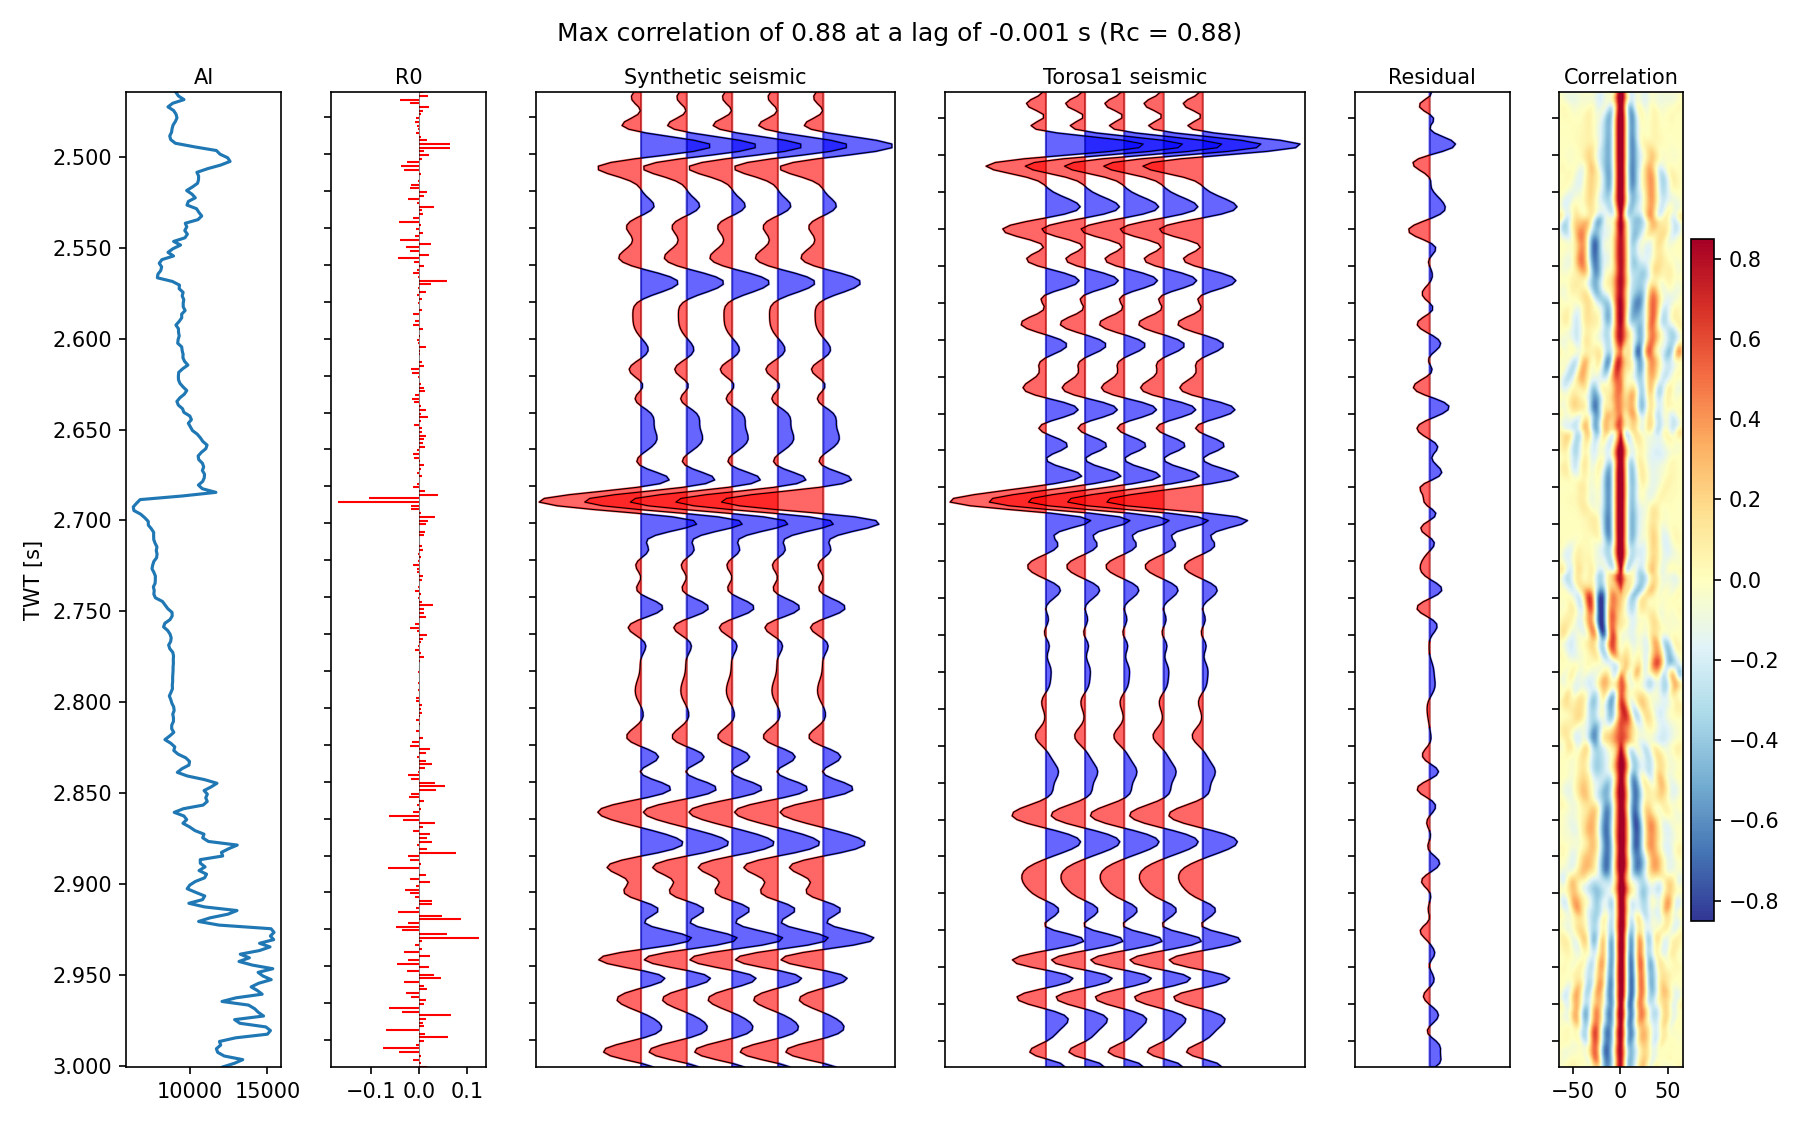

In [14]:
fig, axes = outputs['torosa'].plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

<IPython.core.display.Javascript object>


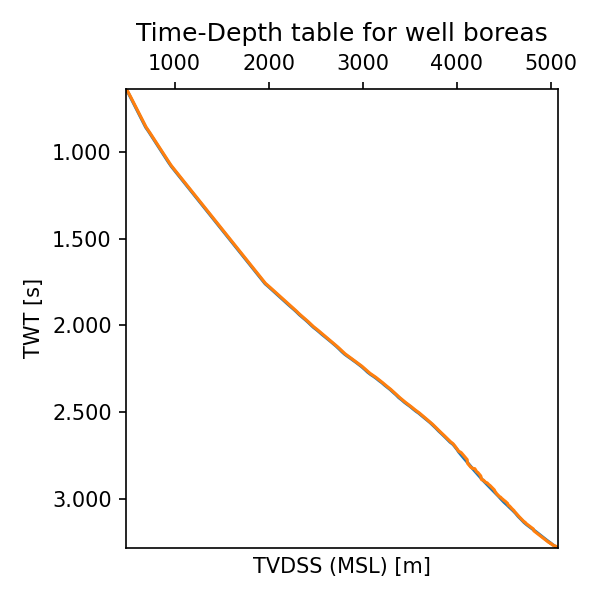

<IPython.core.display.Javascript object>


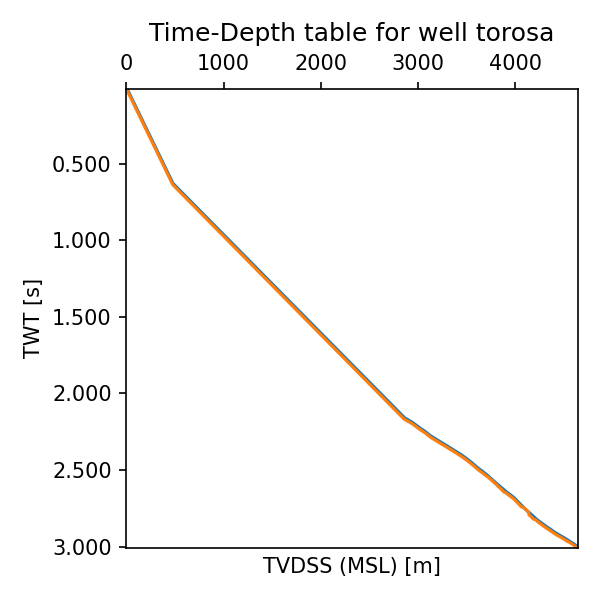

In [15]:
for well in inputs.keys(): 
    fig, ax = viz.plot_td_table(inputs[well].table)
    viz.plot_td_table(outputs[well].table, fig_axes=(fig,ax))
    ax.set_title("Time-Depth table for well %s" % well)

## QC with cross-wavelets

<IPython.core.display.Javascript object>


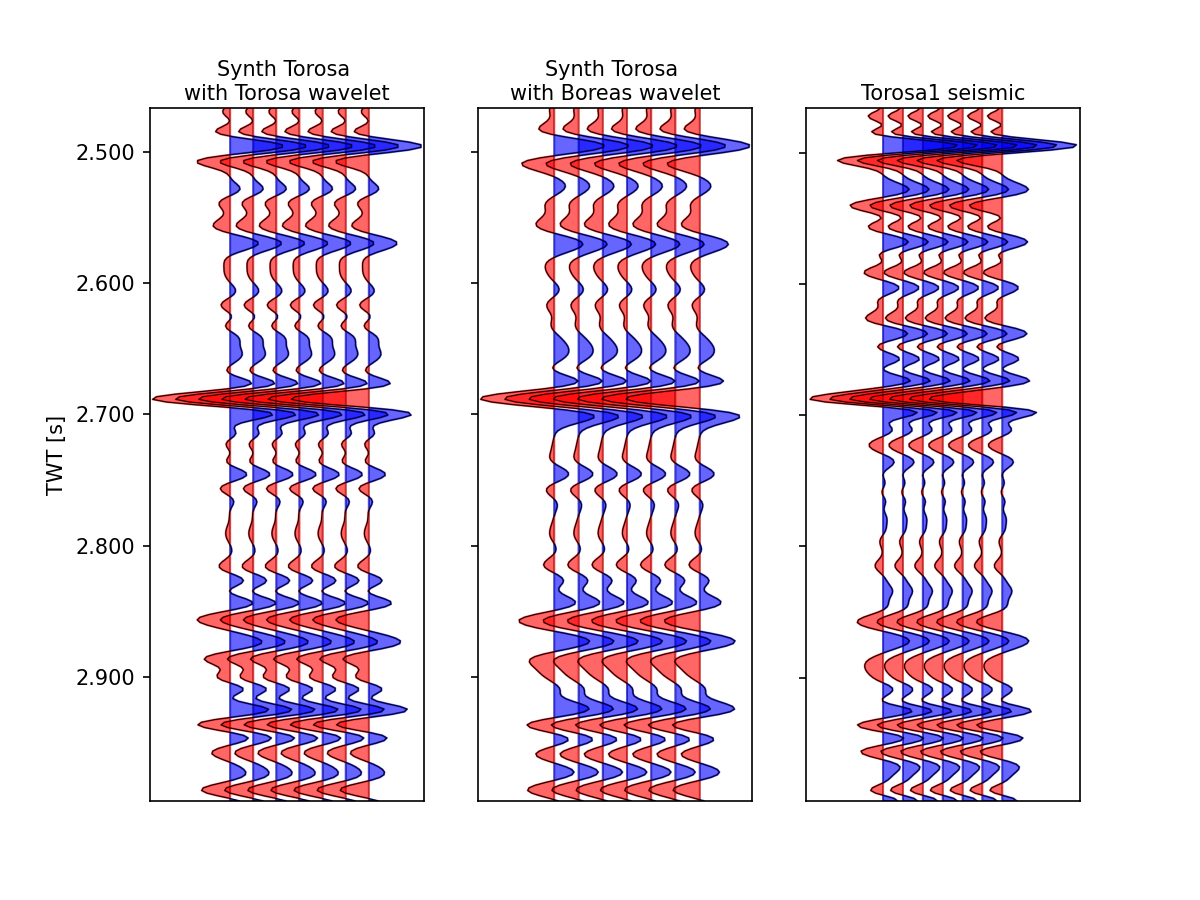

In [16]:
torosa_with_torosa_wlt = tie.compute_synthetic_seismic(modeler,outputs['torosa'].wavelet,outputs['torosa'].r)
torosa_with_torosa_wlt.name = 'Synth Torosa \nwith Torosa wavelet'


torosa_with_boreas_wlt = tie.compute_synthetic_seismic(modeler,outputs['boreas'].wavelet,outputs['torosa'].r)
torosa_with_boreas_wlt.name = 'Synth Torosa \nwith Boreas wavelet'



fig, axes = plt.subplots(1,3, figsize=(8,6))
viz.plot_wiggle_trace(torosa_with_torosa_wlt, scaling=_scale, fig_axes=(fig,axes[0]))
viz.plot_wiggle_trace(torosa_with_boreas_wlt, scaling=_scale, fig_axes=(fig,axes[1]))
viz.plot_wiggle_trace(outputs['torosa'].seismic, scaling=_scale, fig_axes=(fig,axes[2]))

for ax in axes[1:]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

<IPython.core.display.Javascript object>


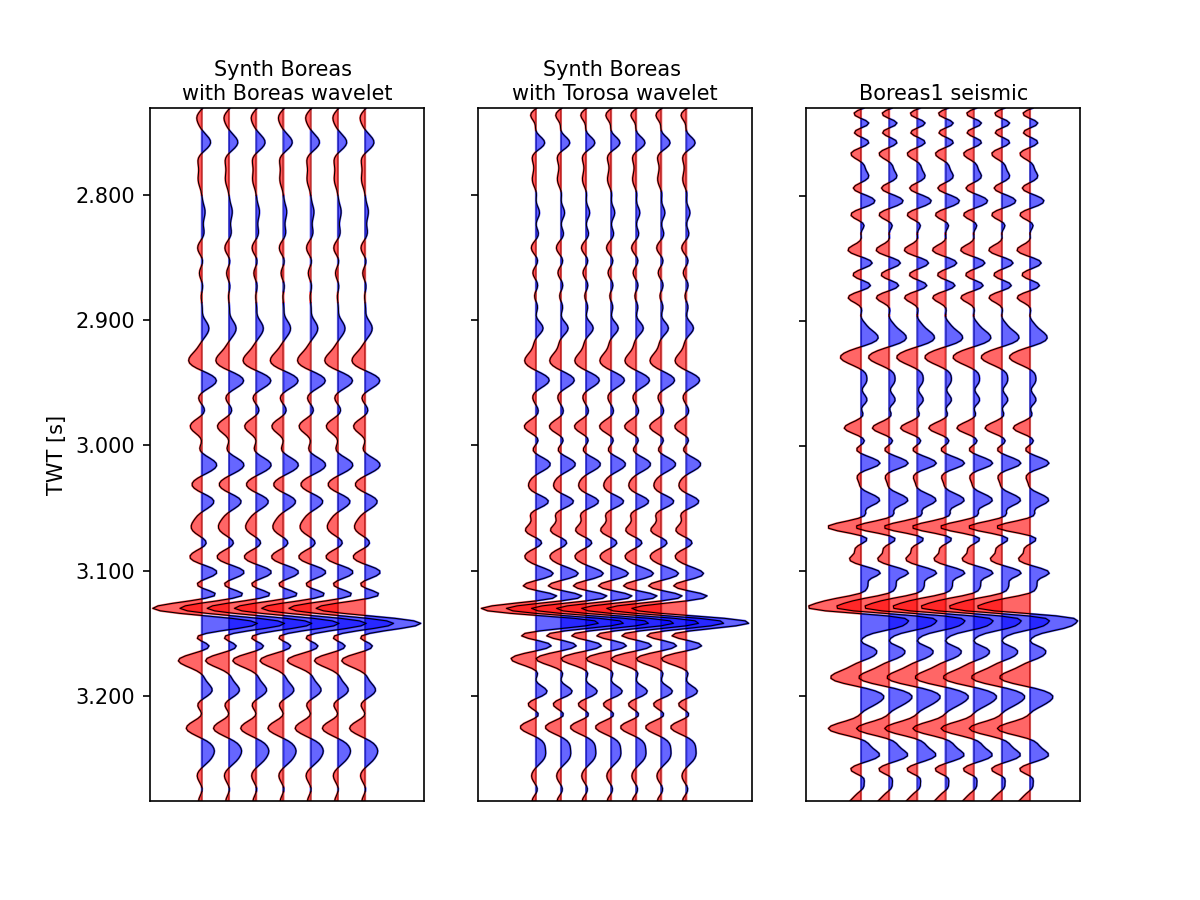

In [17]:
boreas_with_boreas_wlt = tie.compute_synthetic_seismic(modeler,outputs['boreas'].wavelet,outputs['boreas'].r)
boreas_with_boreas_wlt.name = 'Synth Boreas \nwith Boreas wavelet'


boreas_with_torosa_wlt = tie.compute_synthetic_seismic(modeler,outputs['torosa'].wavelet,outputs['boreas'].r)
boreas_with_torosa_wlt.name = 'Synth Boreas \nwith Torosa wavelet'



fig, axes = plt.subplots(1,3, figsize=(8,6))
viz.plot_wiggle_trace(boreas_with_boreas_wlt, scaling=_scale, fig_axes=(fig,axes[0]))
viz.plot_wiggle_trace(boreas_with_torosa_wlt, scaling=_scale, fig_axes=(fig,axes[1]))
viz.plot_wiggle_trace(outputs['boreas'].seismic, scaling=_scale, fig_axes=(fig,axes[2]))

for ax in axes[1:]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

<IPython.core.display.Javascript object>


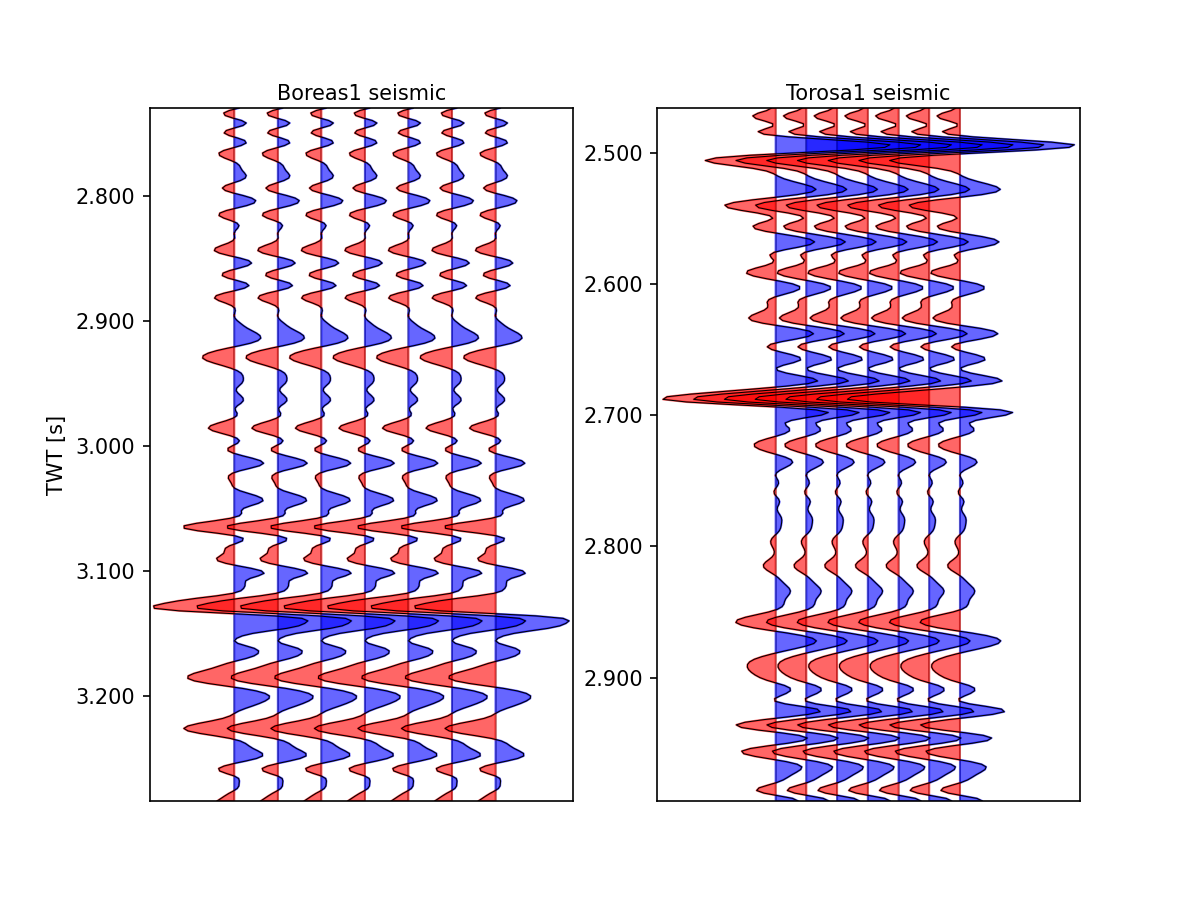

Text(0, 0.5, '')

In [18]:
fig, axes = plt.subplots(1,2, figsize=(8,6))
viz.plot_wiggle_trace(outputs['boreas'].seismic, scaling=_scale, fig_axes=(fig,axes[0]))
viz.plot_wiggle_trace(outputs['torosa'].seismic, scaling=_scale, fig_axes=(fig,axes[1]))
axes[1].set_ylabel("")

<IPython.core.display.Javascript object>


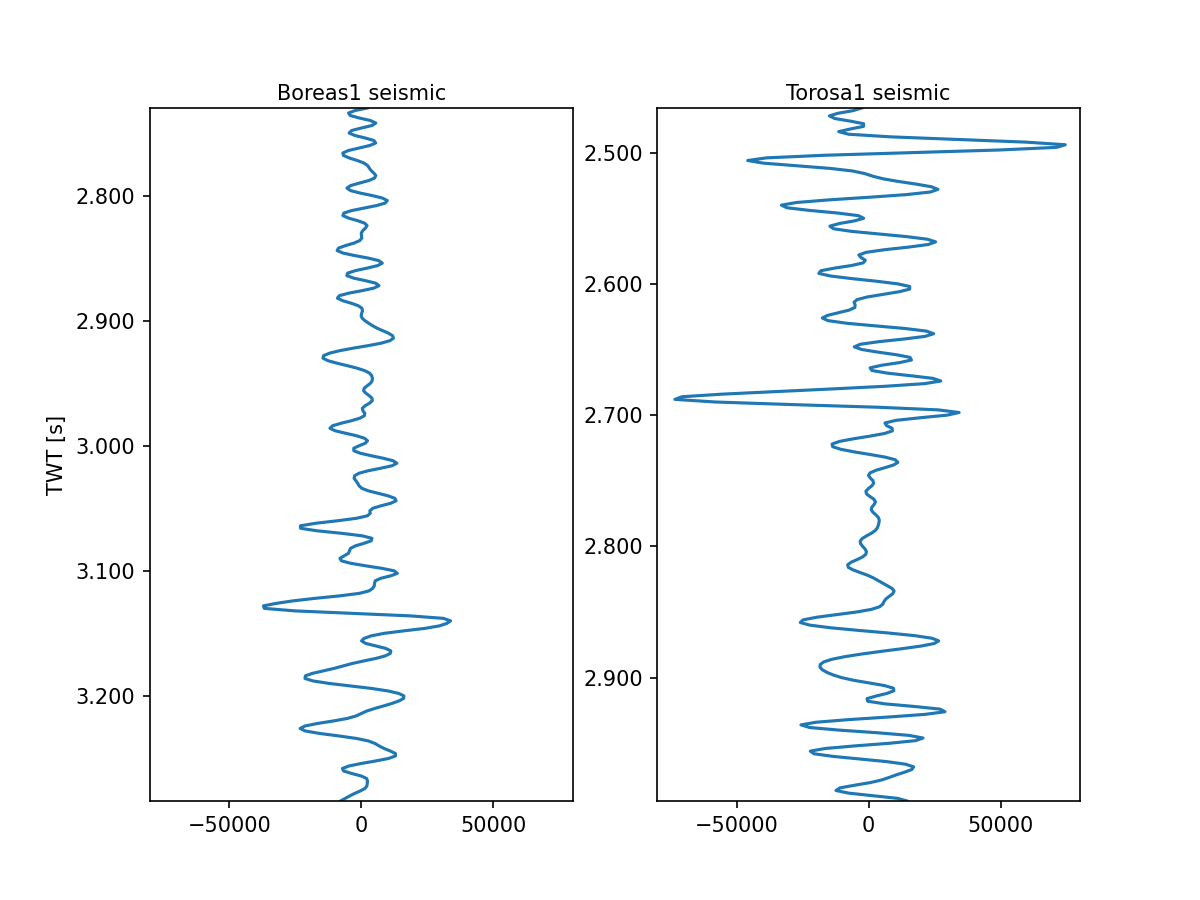

In [19]:
fig, axes = plt.subplots(1,2, figsize=(8,6))
viz.plot_trace(outputs['boreas'].seismic, fig_axes=(fig,axes[0]))
viz.plot_trace(outputs['torosa'].seismic, fig_axes=(fig,axes[1]))
axes[1].set_ylabel("")
for ax in axes:
    ax.set_xlim((-80000,80000))

### sensitivity analysis

In [20]:
inputs['boreas']

InputSet(logset_md=<wtie.processing.grid.LogSet object at 0x7f81cfd70310>, seismic=<wtie.processing.grid.Seismic object at 0x7f81cfd61750>, wellpath=<wtie.processing.grid.WellPath object at 0x7f81cfd613d0>, table=<wtie.processing.grid.TimeDepthTable object at 0x7f81cfd61b50>)

In [21]:
def phase_sensitivity_analysis(inputs: tie.InputSet, wavelet_extractor, modeler):
    seismic = tie.resample_seismic(inputs.seismic, wavelet_extractor.expected_sampling)
    
    wavelets = []
    t_lags = np.arange(-0.016,0.016,0.002)
    for t_lag in t_lags:
        table = grid.TimeDepthTable.t_bulk_shift(inputs.table, t_lag)
    
        logset_twt = tie.convert_logs_from_md_to_twt(inputs.logset_md,
                                               inputs.wellpath,
                                               table,
                                               wavelet_extractor.expected_sampling
                                              )
    
        r = tie.compute_reflectivity(logset_twt)
        seis_match, r_match = tie.match_seismic_and_reflectivity(seismic, r)
    
        wavelet = tie.compute_wavelet(seis_match,
                                    r_match,
                                    modeler,
                                    wavelet_extractor,
                                    zero_phasing=False,
                                    scaling=False,
                                    expected_value=True)
        
        wavelets.append(wavelet)
    
    return wavelets, t_lags

from matplotlib.ticker import FormatStrFormatter

def plot_sensitivity_wavelets(wavelets, lags,
                               figsize =(7,4),
                               scaling: float=1.0,
                               fig_axes: tuple=None
                               ) -> plt.subplots:

    if fig_axes is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig, ax = fig_axes


    for i,lag in enumerate(lags):

        _x = scaling*wavelets[i].values + lag
        ax.plot(_x, wavelets[0].basis, color='k', lw=0.5)
        ax.plot(lag*np.ones_like(_x), wavelets[0].basis, color='k', lw=0.2)

        ax.fill_betweenx(wavelets[0].basis,lag,_x,where=(_x>=lag),
                         color='b', alpha=.6, interpolate=True)
        ax.fill_betweenx(wavelets[0].basis,lag,_x,where=(_x<lag),
                         color='r', alpha=.6, interpolate=True)


    fig.suptitle("Sensitivity analysis")
    ax.set_xlabel("Bulk shifts [s]")
    ax.set_ylim((wavelets[0].basis[0], wavelets[0].basis[-1]))
    ax.invert_yaxis()
    #ax.xaxis.set_label_position("top")
    ax.set_ylabel(wavelets[0].basis_type)

    #_space = 0.05*np.abs(trace.values.max())
    #ax.set_xlim((trace.values.min() - _space, (trace.values.max() + scaling + _space)))
    #ax.set_xticks([])



    if wavelets[0].is_twt:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))



    if fig_axes is None:
        fig.tight_layout()

    return fig, ax

from wtie.processing.spectral import compute_spectrum

def plot_phase_sensitivity(wavelets,lags,
                            figsize =(6,6),
                            fig_axes: tuple=None,
                           fmax=125,
                           phi_min = -90,
                           phi_max=90
                            ) -> plt.subplots:
    phases = []
    for wlt in wavelets:
        ff, ampl, _, phase = compute_spectrum(wlt.values, wlt.sampling_rate,
                                          to_degree=True)
        phases.append(phase)
    
    if fig_axes is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig, ax = fig_axes
        
    for i,p in enumerate(phases):
        ax.plot(ff,p, '+', label=str(lags[i]))
    
    ax.set_xlim((0,fmax))
    ax.set_ylim((phi_min,phi_max))
    
    #ax.legend(loc='best')
    
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Phase [°]")
    return fig,ax

In [22]:
wlts_sensitivity, t_lags = phase_sensitivity_analysis(inputs['boreas'], wavelet_extractor, modeler)

<IPython.core.display.Javascript object>


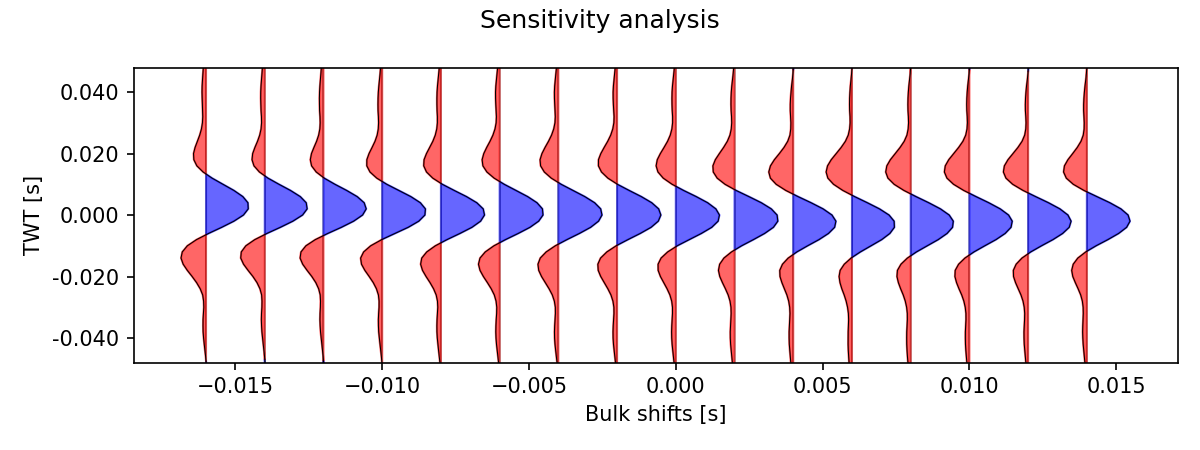

(-0.04800000000000537, 0.04800000000000537)

In [23]:
fig,ax = plot_sensitivity_wavelets(wlts_sensitivity, t_lags, scaling=0.0015, figsize=(8,3))
ax.set_ylim((wlts_sensitivity[0].basis[50],wlts_sensitivity[0].basis[-50]))

<IPython.core.display.Javascript object>


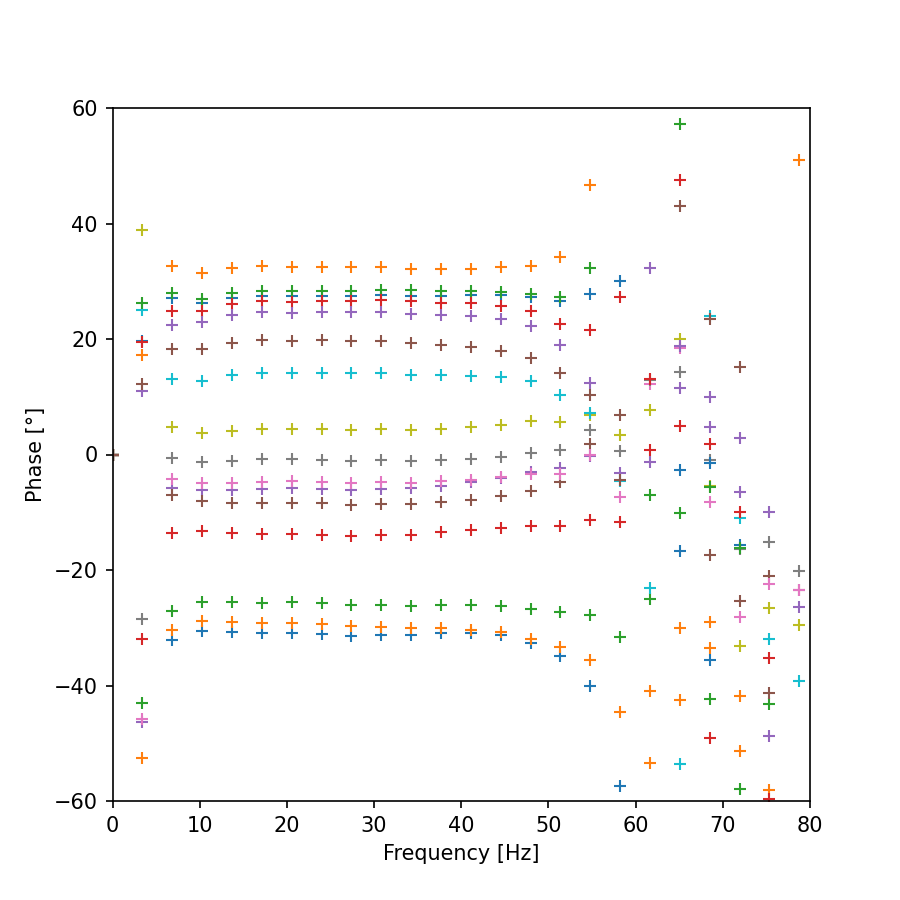

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency [Hz]', ylabel='Phase [°]'>)

In [24]:
plot_phase_sensitivity(wlts_sensitivity, t_lags, fmax=80, phi_min=-60, phi_max=60)

<IPython.core.display.Javascript object>


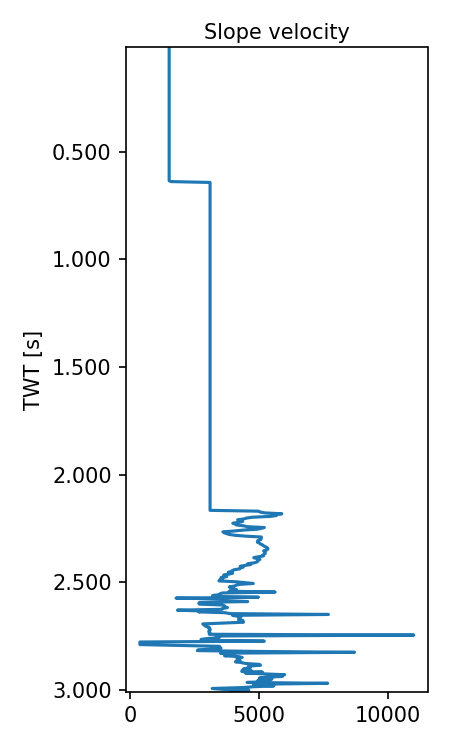

In [25]:
fig, ax = viz.plot_trace(outputs['torosa'].table.slope_velocity_twt())
#viz.plot_trace(outputs2['torosa'].table.slope_velocity_twt(), fig_axes=(fig,ax))